# Analyzing Critical Role

In [344]:
import numpy as np
import pandas as pd
import pathlib
from bs4 import BeautifulSoup
import tqdm
import json
import matplotlib.pyplot as plt
from sklearn import preprocessing as skl_pre
from sklearn import model_selection
import re
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, Embedding, Bidirectional
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [57]:
%matplotlib inline

In [30]:
curdir = pathlib.Path()

In [51]:
def strip_chars(s):
    return s.replace('→', '')

In [162]:
author_map = {}
for row in [[name.strip() for name in line.split(',')] for line in (curdir / 'author_map.txt').read_text().split('\n')]:
    actual_name = row[0]
    author_map[actual_name] = actual_name
    if len(row) > 1:
        for other in row[1:]:
            author_map[other] = actual_name

In [163]:
def clean_author(s):
    return s.strip().replace('# ', '').lower().capitalize()

In [164]:
def parse_html():
    output_file = curdir / 'cr.json'
    if output_file.exists():
        formatted = json.loads(output_file.read_text())
    else:
        parsed = []
        files = list((curdir / 'html').glob('cr2*.html'))
        for file in tqdm.tqdm(files):
            soup = BeautifulSoup(file.read_text())
            text = soup.get_text()
            lines = text.split('\n')
            parsed_lines = []
            author = None
            curline = ''
            for line in lines:
                author_line = line.startswith('# ')

                if not line:
                    continue
                if author is None and not author_line:
                    continue
                if author_line and not curline:
                    author = line
                    continue
                if not author_line:
                    curline += line
                    continue
                if author_line and curline:
                    if ',' in author:
                        for a in author.split(','):
                            parsed_lines.append({'author': author_map[clean_author(a)], 'text': curline, 'file': str(file.name), 'ep': str(file.stem)})
                    else:
                        parsed_lines.append({'author': author_map[clean_author(author)], 'text': curline, 'file': str(file.name), 'ep': str(file.stem)})
                    author = line
                    curline = ''
                    continue
            parsed += parsed_lines
        formatted = [
                {
                    'author': o['author'],
                    'text': strip_chars(o['text']),
                    'file': o['file'],
                    'ep': o['ep'],
                    'season': int(o['ep'].split('-')[0][2:]),
                    'episode': int(o['ep'].split('-')[1]),
                }
                for o in parsed
            ]
        formatted.sort(key=lambda o: (o['season'], o['episode']))
        output_file.write_text(json.dumps(formatted))

    return formatted

In [165]:
json_formatted = parse_html()

100%|██████████| 99/99 [01:00<00:00,  1.63it/s]


In [166]:
df = pd.read_json('cr.json')
df.head()

,author,text,file,ep,season,episode
0,Matt,"Hello, everyone. (laughter) And welcome to ton...",cr2-1.html,cr2-1,2,1
1,Laura,As in nnnn.,cr2-1.html,cr2-1,2,1
2,Matt,"Nnnn. But yeah, so they're going to be a long-...",cr2-1.html,cr2-1,2,1
3,Travis,(vomiting noises) Would you like some?,cr2-1.html,cr2-1,2,1
4,Matt,"So yeah. I'm super excited to have that, guys....",cr2-1.html,cr2-1,2,1


In [240]:
main_cast_probs = df.groupby('author').text.count().sort_values(ascending=False)[:8]
main_cast = list(main_cast_probs.index)
main_cast_probs = main_cast_probs.values / sum(main_cast_probs.values)
list(zip(main_cast, main_cast_probs))

[('Matt', 0.270876811272442),
 ('Laura', 0.14143096073294556),
 ('Sam', 0.1291757322795021),
 ('Travis', 0.11621005579977206),
 ('Marisha', 0.1155847135266344),
 ('Taliesin', 0.09810843213001198),
 ('Liam', 0.0959178840489617),
 ('Ashley', 0.03269541020973018)]

In [241]:
nodes = main_cast
node_lookup = {nodes[i]: i for i in range(len(nodes))}
chain = np.zeros((len(nodes), len(nodes)), dtype=np.float64)

previous = None
for phrase in json_formatted:
    author = phrase['author']
    if author not in nodes:
        continue
    if previous is None:
        previous = author
        continue
        
    chain[node_lookup[previous], node_lookup[author]] += 1
    previous = author
chain = skl_pre.normalize(chain, norm='l1')

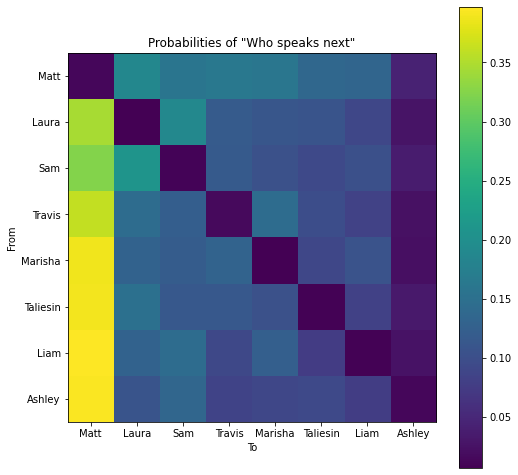

In [247]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
im = ax.imshow(chain, cmap='viridis')
plt.colorbar(im)
ax.set_xticklabels(['a'] + main_cast)
ax.set_yticklabels(['a'] + main_cast)
ax.set_title('Probabilities of "Who speaks next"')
ax.set_xlabel('To')
ax.set_ylabel('From')
plt.show()

In [254]:
def generate_scene(length=30):
    start = np.random.choice(main_cast, 1, p=main_cast_probs)[0]
    scene = [start]
    for i in range(length - 1):
        next_step = np.random.choice(main_cast, 1, p=chain[node_lookup[scene[i]]])[0]
        scene.append(next_step)
    return scene

In [258]:
generate_scene()

['Matt',
 'Sam',
 'Laura',
 'Matt',
 'Ashley',
 'Laura',
 'Travis',
 'Matt',
 'Marisha',
 'Taliesin',
 'Matt',
 'Marisha',
 'Matt',
 'Ashley',
 'Matt',
 'Liam',
 'Matt',
 'Laura',
 'Matt',
 'Travis',
 'Taliesin',
 'Travis',
 'Sam',
 'Matt',
 'Laura',
 'Travis',
 'Matt',
 'Liam',
 'Taliesin',
 'Liam']

In [261]:
main_cast_json = [obj for obj in json_formatted if obj['author'] in main_cast]

In [322]:
def tokenize_sentence(message: str):
    message = message.lower()
    message = re.subn(r'\([a-z]+\)', "", message)[0]
    chars_to_remove = '"#$%()*+-<=>@[\\]^_`{|}~/'
    message = "".join(c for c in message if c not in chars_to_remove)
    message = re.subn(r'(&|,|\.|\?|!)', r" \1 ", message)[0]
    message = re.subn(r'  ', " ", message)[0]
    words = [w for w in re.split(r"\s", message) if w != '']
    return words

In [323]:
tokenize_sentence(main_cast_json[0]['text'])[:10]

['hello',
 ',',
 'everyone',
 '.',
 'and',
 'welcome',
 'to',
 "tonight's",
 'episode',
 'of']

In [324]:
def preprocess(text):
    just_content = [t["text"].lower() for t in text]

    index = 1
    word_index = {}
    sequences = []
    for message in just_content:
        words = tokenize_sentence(message)
        for word in words:
            if word not in word_index:
                word_index[word] = index
                index += 1
        sequences.append([word_index[word] for word in words])

    index_word = {v: k for k, v in word_index.items()}

    for i, seq in enumerate(sequences):
        text[i]["sequence"] = seq
        text[i]["tokenized"] = " ".join(index_word[s] for s in seq)

    return text, word_index, index_word

In [332]:
just_liam = [obj for obj in main_cast_json if obj['author'] == 'Liam']

In [333]:
new_text, word_index, index_word = preprocess(just_liam)

In [334]:
new_text[0]

{'author': 'Liam',
 'text': "That's actually how Purvon dressed. ",
 'file': 'cr2-1.html',
 'ep': 'cr2-1',
 'season': 2,
 'episode': 1,
 'tokenized': "that's actually how purvon dressed .",
 'sequence': [1, 2, 3, 4, 5, 6]}

In [335]:
TIMESTEP = 10
def generate_features_and_labels(text, word_index):
    features = []
    labels = []

    training_length = TIMESTEP
    for message in text:
        sequence = message["sequence"]
        if len(sequence) < training_length:
            continue

        for i in range(training_length, len(sequence)):
            extract = sequence[i - training_length : i + 1]

            features.append(extract[:-1])  # train on first 4
            labels.append(extract[-1])  # label is last

    features = np.array(features)

    # one-hot encode (switch to binary representation) for words
    num_words = len(word_index) + 1
    label_array = np.zeros((len(features), num_words), dtype=np.int8)
    for i, label in enumerate(labels):
        label_array[i, label] = 1

    print(f"Feature Dimensions: {features.shape}")
    print(f"Label Dimensions: {label_array.shape}")

    (
        feature_train,
        feature_test,
        label_train,
        label_test,
    ) = model_selection.train_test_split(
        features, label_array, test_size=0.1, shuffle=True
    )

    return feature_train, feature_test, label_train, label_test

In [338]:
(
    feature_train,
    feature_test,
    label_train,
    label_test,
) = generate_features_and_labels(new_text, word_index)

Feature Dimensions: (139654, 10)
Label Dimensions: (139654, 12576)


In [348]:
def build_model(
    feature_train,
    feature_test,
    label_train,
    label_test,
    word_index,
):
    num_words = len(word_index) + 1

    dim = 25

    # set up model
    model = Sequential()  # Build model one layer at a time
    weights = None
    model.add(
        Embedding(  # maps each input word to 100-dim vector
            input_dim=num_words,  # how many words can input
            input_length=TIMESTEP,  # timestep length
            output_dim=dim,  # output vector
            weights=weights,
            trainable=True,  # update embeddings
        )
    )
    model.add(
        Bidirectional(
            LSTM(64, return_sequences=True, dropout=0.1, recurrent_dropout=0.1),
            input_shape=(TIMESTEP, dim),
        )
    )
    model.add(
        Bidirectional(
            LSTM(64, return_sequences=True, dropout=0.1, recurrent_dropout=0.1)
        )
    )
    model.add(
        Bidirectional(
            LSTM(64, return_sequences=False, dropout=0.1, recurrent_dropout=0.1)
        )
    )
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.25))  # input is rate that things are zeroed
    model.add(Dense(num_words, activation="softmax"))
    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )
    model.summary()

    # train
    callbacks = [
        EarlyStopping(monitor="val_loss", patience=5),
        ModelCheckpoint(
            "./models/model.h5", save_best_only=True, save_weights_only=False
        ),
    ]

    history = model.fit(
        feature_train,
        label_train,
        batch_size=2048,
        epochs=150,
        callbacks=callbacks,
        validation_data=(feature_test, label_test),
    )


In [349]:
build_model(
    feature_train,
    feature_test,
    label_train,
    label_test,
    word_index,
)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 10, 25)            314400    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 10, 128)           46080     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 10, 128)           98816     
_________________________________________________________________
bidirectional_6 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 12576)            

In [351]:
def cleanup(input_string: str) -> str:
    output_string = re.subn(r" ([,\.\!\?])", r"\1", input_string)[0]
    output_string = re.subn(r" i([ ,\.\!\?'])", r" I\1", output_string)[0]

    to_upper = lambda match: match.group(1).upper()
    output_string = re.subn(r"^(\w)", to_upper, output_string)[0]
    to_upper = lambda match: f"{match.group(1)}{match.group(2).upper()}"
    output_string = re.subn(r"([.\!\?] )(\w)", to_upper, output_string)[0]

    if output_string[-1] not in ",.!?":
        output_string += random.choice(",.!?")

    return output_string

In [ ]:
model_dir = pathlib.Path("./models")
model = model_dir / "model.h5"
model = load_model(model)

while True:
    user_input = input("> ")
    null_input = np.ones(TIMESTEP) * word_index["."]
    seq = []
    for word in tokenize_sentence(user_input):
        if word in word_index:
            seq.append(word_index[word])
    if len(seq) == 0:
        continue
    seq = seq[-TIMESTEP:]
    null_input[-len(seq) :] = seq
    start = np.array([null_input], dtype=np.float64)

    response = []
    for i in range(30):
        preds = model.predict(start)[0].astype(np.float64)
        preds = preds / sum(preds)  # normalize
        probas = np.random.multinomial(1, preds, 1)[0]

        next_idx = np.argmax(probas)
        response.append(next_idx)

        if next_idx in [word_index["."], word_index["!"], word_index["?"]]:
            break

        start = np.array([[*start[0], next_idx][-TIMESTEP:]], dtype=np.float64)

    print(cleanup(" ".join(index_word[s] for s in response)))
